In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skimage
import skimage.io as io
import skimage.transform
import matplotlib.cm as cm
import math
from sklearn import *
from sklearn.cross_validation import cross_val_score
%matplotlib inline

In [2]:
def read_img(directory, count=None):
    from os import listdir
    files = [f for f in listdir(directory)]
    files.sort()
    if count is None:
        count = len(files)
    imgs = []
    for i in xrange(count):
        imgs.append(io.imread(directory + files[i])) 
    return files[:count], imgs

In [3]:
def write_csv(filename, pngs, labels):
    with open(filename, 'w') as f:
        f.write('filename,class_id\n')
        for png, label in zip(pngs, labels):
            f.write(str(png) + ',' + str(label) + '\n')

In [4]:
def visualize(images, mod=None):
    i = 0
    while i < len(images):
        vis(images[i:min(i+10, len(images))], mod)
        i += 10
        
def vis(images, mod):
    fig, ax = plt.subplots(ncols=len(images), figsize=( 2 * len(images), 2))
    if len(images) == 1:
        if mod == 'gray':
            ax.imshow(images[0], cmap='gray')
        else:
            ax.imshow(images[0])
        plt.show()
        return
    for ax_i, img in zip(ax, images):
        if mod == 'gray':
            ax_i.imshow(img, cmap='gray')
        else:
            ax_i.imshow(img)
    plt.show()


In [5]:
def to_gray(imgs):
    imgs32 = [skimage.transform.resize(img, (32, 32)) for img in imgs]
    gray_imgs32 = [skimage.color.rgb2gray(img) for img in imgs32]
    return gray_imgs32

In [6]:
df_train = pd.read_csv('gt.csv')
train_pngs, train_imgs = read_img('train/')
train_labels = list(df_train.values[::, 1])

In [7]:
train_grays = to_gray(train_imgs)

Делаем все картинки серыми и меняем их размеры на $32 \cdot 32$.

In [13]:
print (train_labels[::len(train_labels) // 29])

[0, 1, 2, 2, 3, 4, 5, 5, 7, 8, 9, 10, 10, 11, 12, 13, 13, 14, 17, 18, 21, 24, 25, 28, 31, 33, 35, 38, 38, 42]


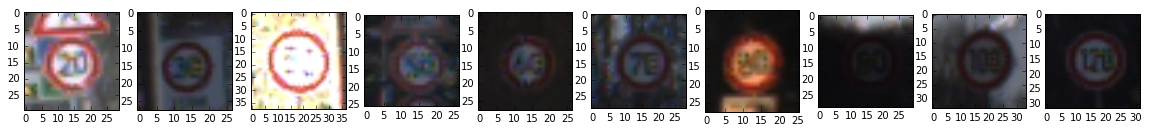

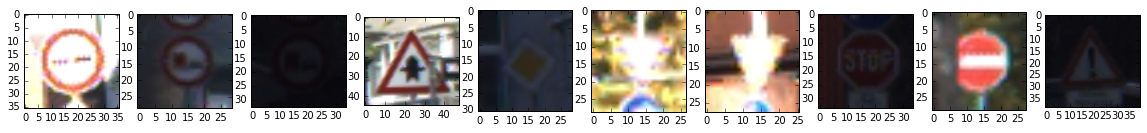

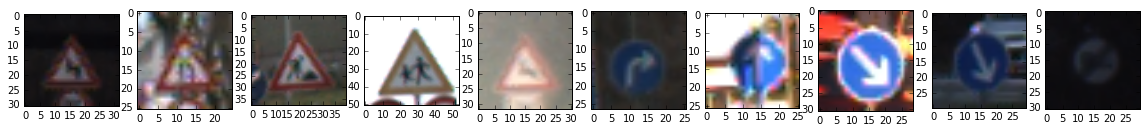

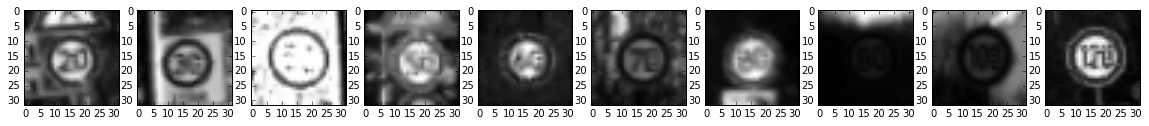

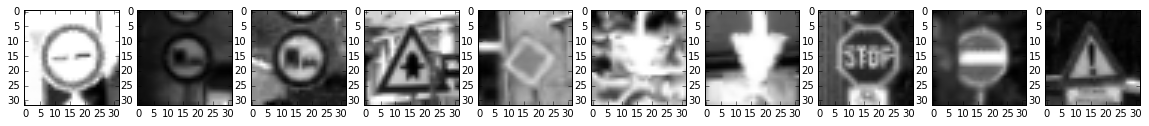

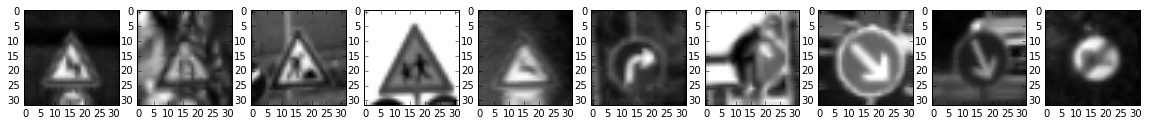

In [14]:
visualize(train_imgs[::len(train_imgs) // 29])
visualize(train_grays[::len(train_grays) // 29], mod='gray')

In [8]:
def calcDerv(img):
    Ix = np.zeros(img.shape)
    Iy = np.zeros(img.shape)
    uuimg = img[0:img.shape[0]-2,1:img.shape[1]-1]
    ddimg = img[2:img.shape[0],1:img.shape[1]-1]
    llimg = img[1:img.shape[0]-1, 0:img.shape[1]-2]
    rrimg = img[1:img.shape[0]-1, 2:img.shape[1]]
    Ix[1:Ix.shape[0]-1, 1:Iy.shape[1]-1] = ddimg - uuimg
    Iy[1:Iy.shape[0]-1, 1:Iy.shape[1]-1] = rrimg - llimg
    return Ix, Iy

def calcSobel(img):
    Ix = np.zeros(img.shape)
    Iy = np.zeros(img.shape)
    uuimg = img[0:img.shape[0]-2, 1:img.shape[1]-1]
    ddimg = img[2:img.shape[0],   1:img.shape[1]-1]
    ulimg = img[0:img.shape[0]-2, 0:img.shape[1]-2]
    drimg = img[2:img.shape[0],   2:img.shape[1]]
    llimg = img[1:img.shape[0]-1, 0:img.shape[1]-2]
    rrimg = img[1:img.shape[0]-1, 2:img.shape[1]]
    luimg = img[0:img.shape[0]-2, 2:img.shape[1]]
    rdimg = img[2:img.shape[0],   0:img.shape[1]-2]
    Ix[1:Ix.shape[0]-1, 1:Iy.shape[1]-1] = (-ulimg + luimg) + 2 * (-llimg + rrimg) + (-rdimg + drimg)
    Iy[1:Iy.shape[0]-1, 1:Iy.shape[1]-1] = ulimg + 2 * uuimg + luimg - rdimg - 2 * ddimg - drimg
    return Ix, Iy

In [9]:
def katan2(Ix, Iy):
    result = np.zeros(Ix.shape)
    for i in xrange(Ix.shape[0]):
        for j in xrange(Ix.shape[1]):
            result[i][j] = (math.atan2(Iy[i][j], Ix[i][j]) + math.pi) / (2 * math.pi)
    return result

In [10]:
def create_hist(img, binCount):
    hist = np.zeros(binCount)
    for i in xrange(img.shape[0] - 1):
        for j in xrange(img.shape[1] - 1):
            index = int(img[i][j] * binCount)
            if index < 0:
                index = 0
            if index >= binCount:
                index = binCount - 1
            hist[index] += 1
    return hist

In [11]:
def calc_hogs(rel_grad, cellRows=4, cellCols=4, binCount=8):
    hogs = np.zeros((rel_grad.shape[0] / cellRows, \
                    rel_grad.shape[1] / cellCols, \
                    binCount))
    for i in xrange(rel_grad.shape[0] / cellRows - 1):
        for j in xrange(rel_grad.shape[1] / cellCols - 1):
            hogs[i][j] = create_hist(rel_grad[cellRows*i:cellRows*(i+1)+1, \
                                               cellCols*j:cellCols*(j+1)+1],\
                                      binCount)
    return hogs
            
def calc_blocks(hogs, cellRows=4, cellCols=4, blockCellRows=12, blockCellCols=12):
    wid_r = blockCellRows / cellRows
    wid_c = blockCellCols / cellCols
    blocks = np.zeros((hogs.shape[0] - wid_r + 1,\
                       hogs.shape[1] - wid_c + 1,\
                       hogs.shape[2] * wid_r * wid_c))
    for i in xrange(hogs.shape[0] - wid_r + 1):
        for j in xrange(hogs.shape[1] - wid_c + 1):
            hists = []
            for di in xrange(wid_r):
                for dj in xrange(wid_c):
                    hists += list(hogs[i + di][j + dj])
            blocks[i][j] = np.array(hists)
            blocks[i][j] /= np.sum(np.square(blocks[i][j])) ** 0.5
    return blocks
    

In [12]:
def extract_hog(img):
    Ix, Iy = calcSobel(img)
    abs_grad = (Ix * Ix + Iy * Iy) ** 0.5
    rel_grad = katan2(Ix, Iy)
    hogs = calc_hogs(rel_grad, 4, 4, 12)
    blocks = calc_blocks(hogs, 4, 4, 12, 12) 
    return blocks.reshape(blocks.shape[0] * blocks.shape[1] * blocks.shape[2])
    

In [13]:
def fit_and_classify(hogs, train_labels):
    clf = svm.SVC(kernel='linear', C=1)
    scores = cross_val_score(clf, hogs, train_labels, cv=5)
    print (scores)
    clf.fit(hogs, train_labels)
    return clf


In [14]:
train_hogs = [extract_hog(img) for img in train_grays[::]]

Извлекаем HOG-признаки из изображений. Параметры --- cellRows = cellCols = 4, blockCellRows = blockCellCols = 12, binCount = 12. Это не самые оптимальные параметры --- исследования показали, что более оптимальными будут 4, 4, 20, 20, 12 соответственно, но тогда они занимали бы чересчур много памяти и моя машина не тянула бы.

In [15]:
clf = fit_and_classify(train_hogs, train_labels[::])

[ 0.93458301  0.94491201  0.9461872   0.94248916  0.94362964]


Предсказанное качество классификатора от $93.4\%$ до $94.6\%$, но на Kaggle результат примерно $92.9\%$. Исследования предсказали качество для параметров, упомянутых в предыдущем пункте примерно $95.2\%$, что, по всей видимости, улучшило бы результат на Kaggle до $93-94\%$, но проверить это не удается:) 

In [16]:
test_pngs, test_imgs = read_img('test/')
print (len(test_pngs))
print (len(test_imgs))

12342
12342


In [17]:
print (len(test_imgs))
test_grays = to_gray(test_imgs)

12342


In [18]:
test_hogs = [extract_hog(img) for img in test_grays]

In [19]:
test_labels = clf.predict(test_hogs)

In [20]:
write_csv('svm5.csv', test_pngs, test_labels)

Записываем результат .csv, в клетках ниже смотрим, что получилось, на глазок.

In [34]:
print (test_labels[::len(test_labels) // 29])

[ 6  2 25 31 10  5  1  3 42 40 10 35  1  5 20  2 25 14 35 14  4 41 17  9  2
  3  9  3 13 12]


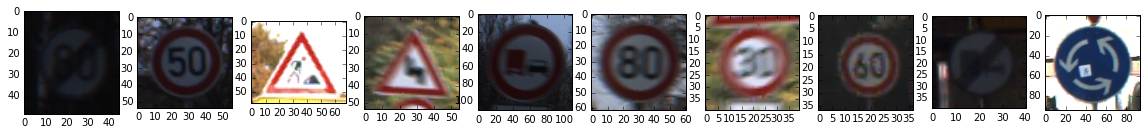

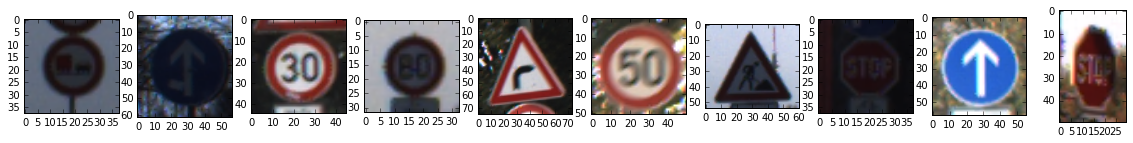

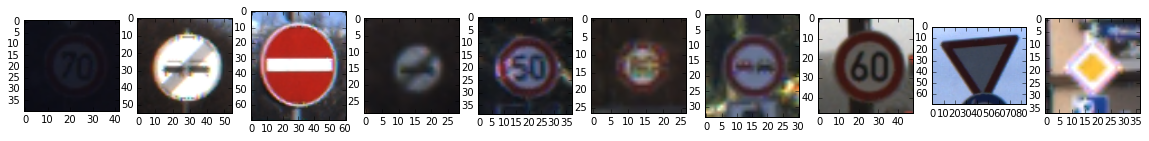

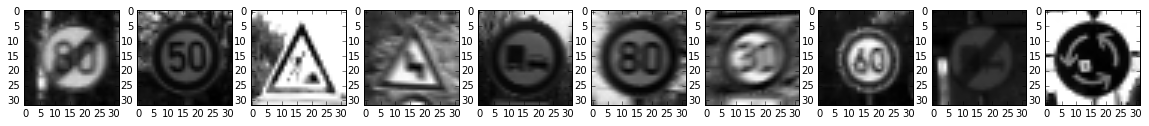

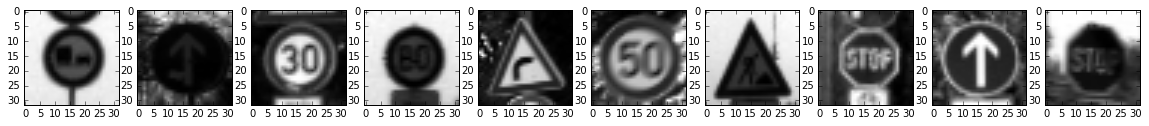

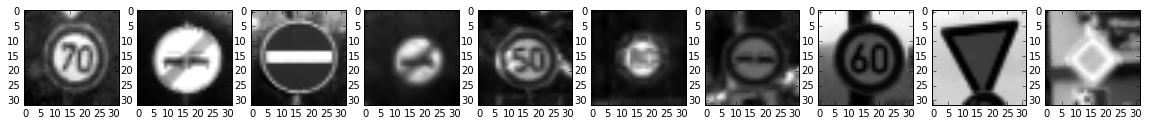

In [35]:
visualize(test_imgs[::len(test_imgs) // 29])
visualize(test_grays[::len(test_grays) // 29], mod='gray')
